# Demo: Model selection + runner service

This notebook demonstrates the end-to-end service: given a spatio-temporal input series, our selector chooses a library and model, and we dispatch to the corresponding adapter in `app.model_runner` to produce forecasts.

In [1]:
import json
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# Use the high-level service wrapper
from app.runner_service import run_service
# Create an explicit VectorDB instance and use it in the demo
from app.vector_db import VectorDB
# instantiate the DB (you can pass backend/faiss options to the constructor)
db = VectorDB()

OUT = Path('outputs')
OUT.mkdir(exist_ok=True)
plt.rcParams['figure.figsize'] = (10,4)

# Как подготовить векторную базу данных (vector_db)

Перед запуском демо полезно убедиться, что векторная база инициализирована и содержит seed-документы (описания моделей). В ноутбуке мы используем `app.vector_db`.

Короткая инструкция:

1. При первом запуске вызовите `vector_db.initialize()` — это подготовит бэкенд (FAISS/Chroma/memory).
2. Затем вызовите `vector_db.seed_default_models()` — это добавит предопределённые описания моделей в индекс.
3. В продакшен/повторных запусках можно настроить переменные окружения:
   - `EMBED_MODEL` — имя модели для эмбеддингов (например, sentence-transformers), если хотите улучшенные эмбеддинги;
   - `FAISS_PATH` — путь к файлу FAISS-индекса для персистентного хранения.

Пример (ниже в ноутбуке есть код, который выполняет эти шаги автоматически — он обработает исключения, если индекс уже инициализирован):


In [2]:
from sentence_transformers import SentenceTransformer; SentenceTransformer('all-MiniLM-L6-v2')

SentenceTransformer(
  (0): Transformer({'max_seq_length': 256, 'do_lower_case': False, 'architecture': 'BertModel'})
  (1): Pooling({'word_embedding_dimension': 384, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False, 'pooling_mode_weightedmean_tokens': False, 'pooling_mode_lasttoken': False, 'include_prompt': True})
  (2): Normalize()
)

In [3]:
# Initialize or load the vector DB used by the RAG selector
# If this is the first run, seed_default_models() will populate the index with defaults.
try:
    db.initialize()
except Exception as e:
    print('db.initialize warning:', e)


In [4]:
# Seed default docs/models into the DB if empty or for demo reproducibility
try:
    db.seed_default_models()
except Exception as e:
    print('db.seed_default_models warning:', e)

# Demo: try saving and loading the index to disk (wrapped in try/except to be backend-safe)
save_path = OUT / 'vector_db_index'
try:
    db.save(str(save_path))
    print('Saved vector DB to', save_path)
except Exception as e:
    print('db.save warning:', e)

# Demonstrate loading into a fresh instance (if save succeeded)
try:
    from app.vector_db import VectorDB
    db2 = VectorDB()
    db2.load(str(save_path))
    print('Loaded vector DB into db2; db2.available() ->', getattr(db2, 'available', lambda: None)())
except Exception as e:
    print('db.load demo warning:', e)

Saved vector DB to outputs/vector_db_index
Loaded vector DB into db2; db2.available() -> memory


In [5]:
# Optional: try a real FAISS save/load demo (requires faiss installed and writable filesystem)
try:
    db_faiss = VectorDB(backend='faiss', faiss_path=str(OUT / 'faiss_index_demo'), faiss_autosave=False)
    ok = db_faiss.initialize()
    print('db_faiss backend ->', db_faiss.available(), 'initialize returned', ok)
    # seed and persist
    db_faiss.seed_default_models()
    try:
        idx_path, meta_path = db_faiss.save(str(OUT / 'faiss_index_demo'))
        print('FAISS saved to', idx_path, meta_path)
    except Exception as e:
        print('FAISS save failed:', e)
    # load into a fresh instance
    try:
        db_faiss2 = VectorDB(backend='faiss')
        db_faiss2.load(str(OUT / 'faiss_index_demo'))
        print('FAISS loaded into db_faiss2; backend ->', db_faiss2.available())
    except Exception as e:
        print('FAISS load failed:', e)
except Exception as e:
    print('FAISS demo skipped or failed (faiss may not be installed or filesystem not writable):', e)

db_faiss backend -> faiss initialize returned True
FAISS saved to outputs/faiss_index_demo.index outputs/faiss_index_demo.meta.json
FAISS loaded into db_faiss2; backend -> faiss
FAISS saved to outputs/faiss_index_demo.index outputs/faiss_index_demo.meta.json
FAISS loaded into db_faiss2; backend -> faiss


## 1) Generate synthetic data

In [6]:
def gen_univariate(T=250, seed=0):
    rng = np.random.default_rng(seed)
    t = np.arange(T)
    x = 0.02 * t + np.sin(2*np.pi*t/24) + rng.normal(scale=0.3, size=T)
    return x

def gen_sensors(T=250, S=12, seed=1):
    rng = np.random.default_rng(seed)
    pos = rng.random((S,2))
    base = rng.normal(scale=0.5, size=S)
    X = np.zeros((T,S))
    X[0] = base
    for t in range(1,T):
        X[t] = 0.8 * X[t-1] + 0.2 * (rng.normal(scale=0.1, size=S)) + 0.1 * np.sin(2*np.pi*t/30)
    return X, pos

uni = gen_univariate()
sensors, positions = gen_sensors(T=250, S=16)
print('uni shape', uni.shape, 'sensors shape', sensors.shape)

uni shape (250,) sensors shape (250, 16)


## 2) Model selection (heuristic / selector)

In [7]:
# Use run_service to select and run models in one call (new signature)
# The service now takes a vector DB instance instead of an explicit candidates list.
res_uni = run_service('univariate series with daily seasonality', uni, db=db, task='forecast', horizon=12)  # type: ignore[arg-type]
print('uni choice =', res_uni['choice'])
y_pred_uni = res_uni['result']['y_pred']
# ensure numpy array and show both raw and squeezed-last shapes
import numpy as _np
y_pred_uni = _np.asarray(y_pred_uni)
print('uni pred shape (raw):', getattr(y_pred_uni, 'shape', None))
print('uni pred shape (squeezed last):', getattr(y_pred_uni.squeeze(-1), 'shape', None))

res_s = run_service('sensor network with spatial relations', sensors, db=db, task='forecast', horizon=8)  # type: ignore[arg-type]
print('sensors choice =', res_s['choice'])
y_pred_s = res_s['result']['y_pred']
y_pred_s = _np.asarray(y_pred_s)
print('sensors pred shape (raw):', getattr(y_pred_s, 'shape', None))
print('sensors pred shape (squeezed last):', getattr(y_pred_s.squeeze(-1), 'shape', None))

Device set to use cuda:0
The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
/home/sasha/llm-ida/.venv/lib/python3.12/site-packages/fs/__init__.py:4: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  __import__("pkg_resources").declare_namespace(__name__)  # type: ignore
/home/sasha/llm-ida/.venv/lib/python3.12/site-packages/fs/__init__.py:4: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  _

uni choice = {'library': 'sktime', 'model_name': 'AutoARIMA'}
uni pred shape (raw): (12, 1, 1)
uni pred shape (squeezed last): (12, 1)


Device set to use cuda:0
/home/sasha/llm-ida/.venv/lib/python3.12/site-packages/statsforecast/arima.py:479: UserWarning: possible convergence problem: minimize gave code 2]
  warnings.warn(
/home/sasha/llm-ida/.venv/lib/python3.12/site-packages/statsforecast/arima.py:479: UserWarning: possible convergence problem: minimize gave code 2]
  warnings.warn(
/home/sasha/llm-ida/.venv/lib/python3.12/site-packages/statsforecast/arima.py:479: UserWarning: possible convergence problem: minimize gave code 2]
  warnings.warn(
/home/sasha/llm-ida/.venv/lib/python3.12/site-packages/statsforecast/arima.py:479: UserWarning: possible convergence problem: minimize gave code 2]
  warnings.warn(
/home/sasha/llm-ida/.venv/lib/python3.12/site-packages/statsforecast/arima.py:479: UserWarning: possible convergence problem: minimize gave code 2]
  warnings.warn(
/home/sasha/llm-ida/.venv/lib/python3.12/site-packages/statsforecast/arima.py:479: UserWarning: possible convergence problem: minimize gave code 2]
  

sensors choice = {'library': 'sktime', 'model_name': 'AutoARIMA'}
sensors pred shape (raw): (8, 16, 1)
sensors pred shape (squeezed last): (8, 16)


In [8]:
args = {}
from sktime.forecasting.statsforecast import StatsForecastAutoARIMA  # type: ignore
a = StatsForecastAutoARIMA(**args) if args and len(args) > 0 else StatsForecastAutoARIMA()

In [9]:
y_pred_uni

array([[[5.3792663]],

       [[5.1498284]],

       [[4.8419456]],

       [[4.563239 ]],

       [[4.355431 ]],

       [[4.223068 ]],

       [[4.1534305]],

       [[4.128672 ]],

       [[4.1321716]],

       [[4.151092 ]],

       [[4.176768 ]],

       [[4.204062 ]]], dtype=float32)

In [10]:
y_pred_s

array([[[0.30955404],
        [0.41324303],
        [0.38330635],
        [0.48051277],
        [0.35092217],
        [0.33727577],
        [0.33870438],
        [0.3486334 ],
        [0.3785429 ],
        [0.4512119 ],
        [0.35829324],
        [0.3753635 ],
        [0.37425384],
        [0.38341624],
        [0.40487424],
        [0.3106325 ]],

       [[0.3238042 ],
        [0.40925393],
        [0.37706476],
        [0.49856582],
        [0.364578  ],
        [0.35945666],
        [0.33819062],
        [0.3494834 ],
        [0.38455233],
        [0.4685995 ],
        [0.3582081 ],
        [0.3796657 ],
        [0.36885837],
        [0.40995234],
        [0.40704095],
        [0.30616236]],

       [[0.3165838 ],
        [0.3846321 ],
        [0.36380637],
        [0.49112332],
        [0.35522577],
        [0.3567757 ],
        [0.32778332],
        [0.3377321 ],
        [0.37951183],
        [0.46263212],
        [0.3367231 ],
        [0.36400557],
        [0.3546038 ],
      

## 3) Run selected model(s)

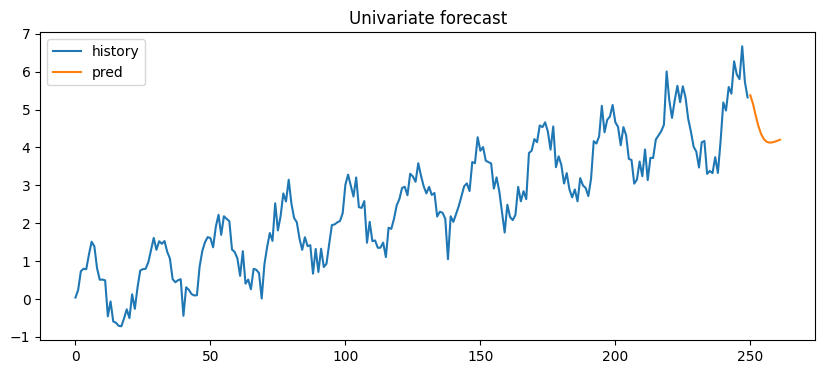

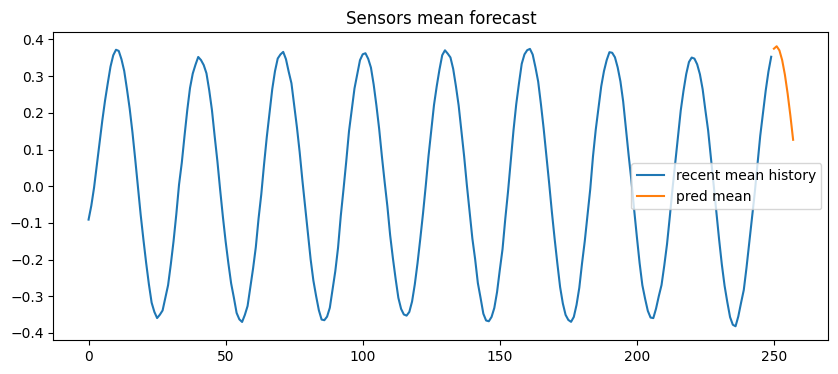

In [11]:
# plotting helpers
import matplotlib.pyplot as plt
import numpy as _np
def plot_uni(history, pred_arr):
    try:
        pred_arr = _np.asarray(pred_arr)
        # normalize to 1D prediction
        if pred_arr.ndim == 3:
            preds = pred_arr[:, 0, 0]
        elif pred_arr.ndim == 2:
            preds = pred_arr.reshape(-1)
        else:
            preds = pred_arr.reshape(-1)
        h = preds.shape[0]
        T = len(history)
        plt.figure()
        plt.plot(_np.arange(T), history, label='history')
        plt.plot(_np.arange(T, T+h), preds, label='pred')
        plt.legend(); plt.title('Univariate forecast'); plt.show()
    except Exception as e:
        print('plot_uni error:', e)

def plot_sensors_mean(history, pred_arr):
    try:
        history = _np.asarray(history)
        pred_arr = _np.asarray(pred_arr)
        # Normalize pred_arr to (H, S)
        if pred_arr.ndim == 3:
            preds = pred_arr[:, :, 0]
        elif pred_arr.ndim == 2:
            preds = pred_arr
        elif pred_arr.ndim == 1:
            preds = pred_arr.reshape(-1, 1)
        else:
            preds = pred_arr.reshape((pred_arr.shape[0], -1))
        # history may be 1D (T,) or 2D (T, S)
        if history.ndim == 1:
            mean_hist = history
        else:
            mean_hist = history.mean(axis=1)
        # compute preds mean across sensors
        if preds.ndim == 1:
            preds_mean = preds
        else:
            preds_mean = preds.mean(axis=1)
        H = preds_mean.shape[0]
        plt.figure()
        plt.plot(mean_hist[:], label='recent mean history')
        plt.plot(_np.arange(len(mean_hist), len(mean_hist)+H), preds_mean, label='pred mean')
        plt.legend(); plt.title('Sensors mean forecast'); plt.show()
    except Exception as e:
        print('plot_sensors_mean error:', e)

# run plots (safe)
plot_uni(uni, y_pred_uni)
plot_sensors_mean(sensors, y_pred_s)

## 4) Save summary

In [12]:
summary = {
    'uni_choice': res_uni['choice'],
    'sensors_choice': res_s['choice'],
    'uni_pred_shape': list(getattr(res_uni['result']['y_pred'], 'shape', [])),
    'sensors_pred_shape': list(getattr(res_s['result']['y_pred'], 'shape', []))
}
with open(OUT / 'runner_demo_summary.json', 'w') as f:
    json.dump(summary, f, indent=2)
print('saved outputs/runner_demo_summary.json')

saved outputs/runner_demo_summary.json
